In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu
from matplotlib.pyplot import subplot_mosaic as mosaic
import matplotlib.transforms as mtransforms
import math
import matplotlib

## Preparations

In [47]:
cwd = os.getcwd()
n = 100 # nb of random partitions
k = 5000 # nb of max top_k_edges selected
m = 10 # number of iterations on confounder-based partitions
ct_sels = ['BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'PCPG', 'READ', 'STAD']
confs = ['age_at_initial_pathologic_diagnosis', 'race.demographic', 'gender.demographic', 'tumor_stage.diagnoses']
algs = ['ARACNE', 'CEMITOOL', 'GRNBOOST2', 'WGCNA'] # string identifiers of algorithms
alpha = 0.05

## Read data from Jaccard Indices for all tools, confounders, cohorts and partition types

In [48]:
JI = pd.DataFrame(columns = ['Confounder/\nvariable', 'Cohort', 'Method', 'Partition type', 'partID', 'k', 'mean JI'])
for alg_sel in algs:
    for conf_sel in confs:
        for ct_sel in ct_sels:
            path = os.path.join(cwd, alg_sel, str(ct_sel))#'JI_'+str(alg_sel)+'_'+str(ct_sel))
            for i in range(m):
                try:
                    filename = f'cb_{i}_{alg_sel}_{conf_sel}_{ct_sel}_jaccInd.csv'
                    filename = os.path.join(path, filename)
                    df_conf = pd.read_csv(filename, sep=',', header=0)
                    df_conf['partID'] = i
                    df_conf['Partition type'] = 'confounder-based partition'
                    df_conf['Method'] = alg_sel
                    df_conf['Cohort'] = ct_sel
                    df_conf['Confounder/\nvariable'] = conf_sel
                    JI = pd.concat([JI, df_conf])
                except:
                    print(filename)
                    continue
print(JI)
for alg_sel in algs:
    for conf_sel in confs:
        for ct_sel in ct_sels:
            path = os.path.join(cwd, alg_sel, str(ct_sel))#'JI_'+str(alg_sel)+'_'+str(ct_sel))
            for i in range(n):
                filename = 'rnd'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                try:
                    df_rnd = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                    df_rnd['partID'] = i
                    df_rnd['Partition type'] = 'random partition'
                    df_rnd['Method'] = alg_sel
                    df_rnd['Cohort'] = ct_sel
                    df_rnd['Confounder/\nvariable'] = conf_sel
                except:
                    #print(filename)
                    continue
                JI = pd.concat([JI, df_rnd])
JI_all = JI.copy()
JI_all['Confounder/\nvariable'] = JI_all['Confounder/\nvariable'].replace(['race'], 'ethnicity')
JI_all['Confounder/\nvariable'] = JI_all['Confounder/\nvariable'].replace(['race.demographic'], 'ethnicity')
JI_all['Confounder/\nvariable'] = JI_all['Confounder/\nvariable'].replace(['gender.demographic'], 'sex')
JI_all['Confounder/\nvariable'] = JI_all['Confounder/\nvariable'].replace(['tumor_stage.diagnoses'], 'stage')
JI_all['Confounder/\nvariable'] = JI_all['Confounder/\nvariable'].replace(['age_at_initial_pathologic_diagnosis'], 'age')
JI_all.rename(columns={'mean JI': 'Mean JI'}, inplace=True)
confs = ['age', 'ethnicity', 'sex', 'stage']
JI_all = JI_all[JI_all['k']%100 == 10]
JI_all['Method'] = JI_all['Method'].replace(['ARACNE'], 'ARACNe-AP').replace(['CEMITOOL'], 'CEMiTool').replace(['GRNBOOST2'], 'GRNBoost2')
JI_all['Cohort x\nConfounder'] = JI_all['Cohort'] + ' x ' + JI_all['Confounder/\nvariable']
JI_all.reset_index(inplace=True)

/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_0_ARACNE_race.demographic_GBM_jaccInd.csv
/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_1_ARACNE_race.demographic_GBM_jaccInd.csv
/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_2_ARACNE_race.demographic_GBM_jaccInd.csv
/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_3_ARACNE_race.demographic_GBM_jaccInd.csv
/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_4_ARACNE_race.demographic_GBM_jaccInd.csv
/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_5_ARACNE_race.demographic_GBM_jaccInd.csv
/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_6_ARACNE_race.demographic_GBM_jaccInd.csv
/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_7_ARACNE_race.demographic_GBM_jaccInd.csv
/Users/dbblumenthal/code/pycharm/grn-confounders/results/ARACNE/GBM/cb_8_ARACNE_race.demographic

## Generate plots for supplement

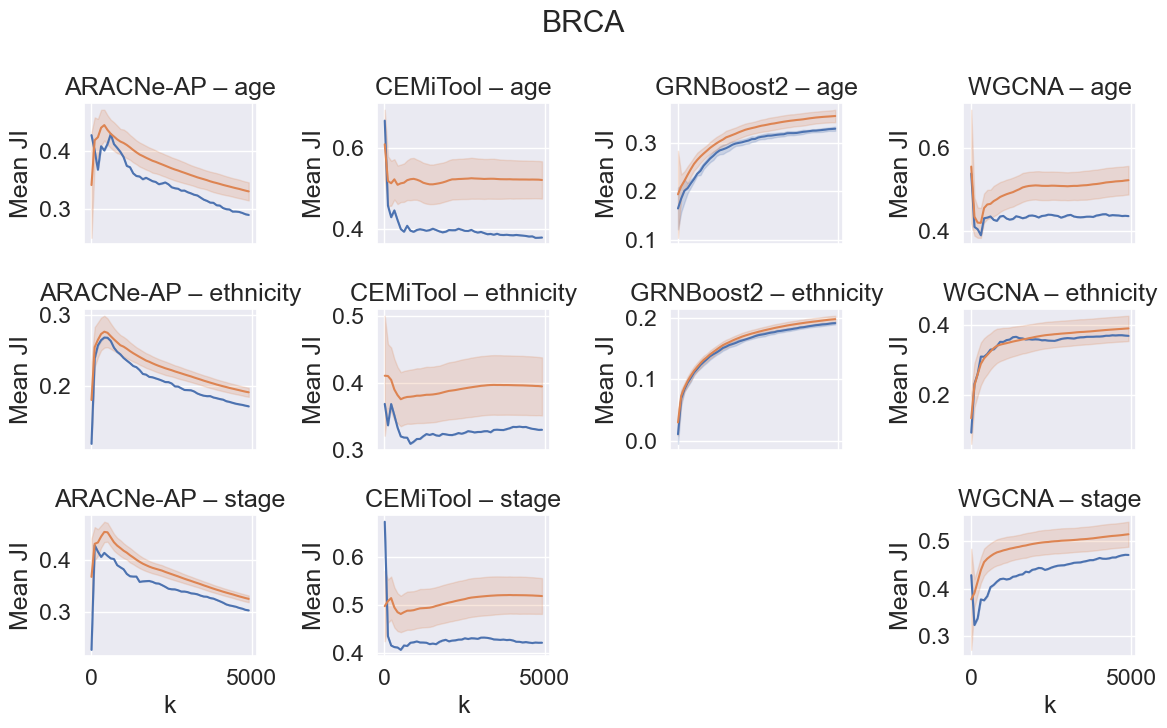

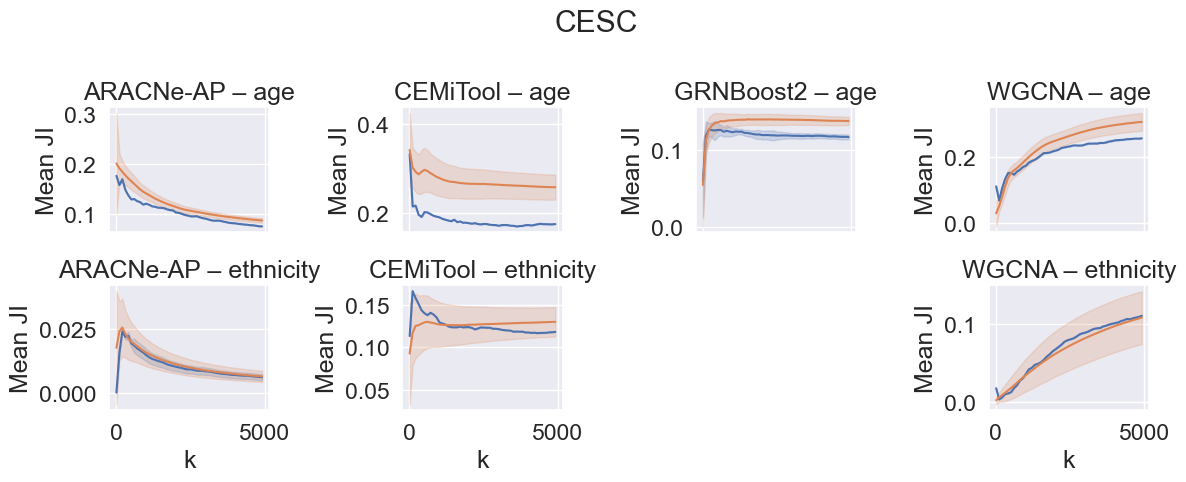

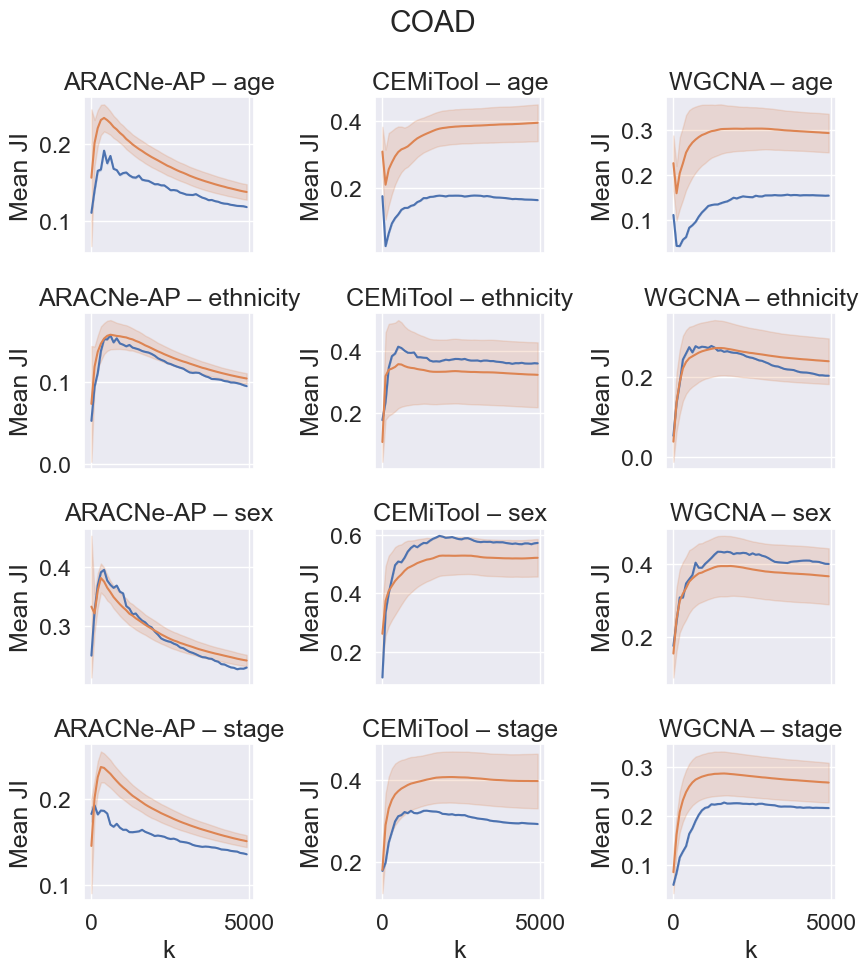

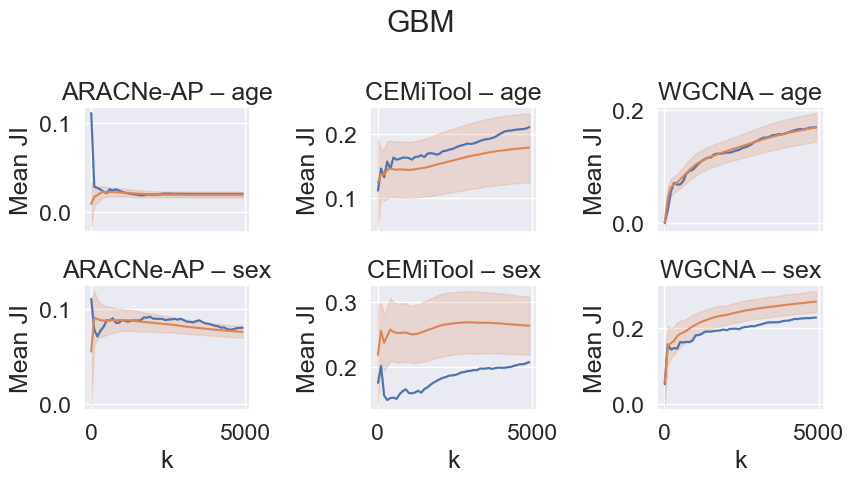

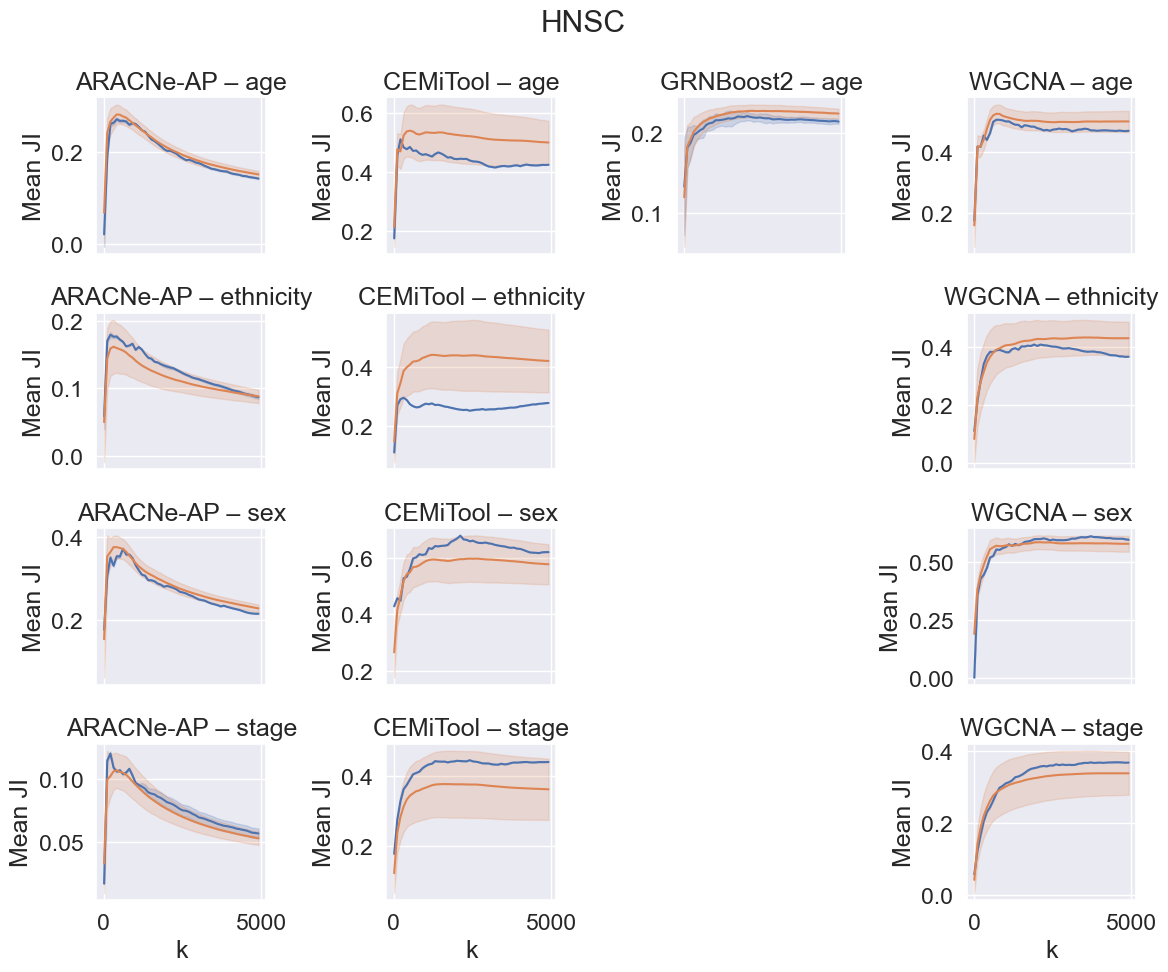

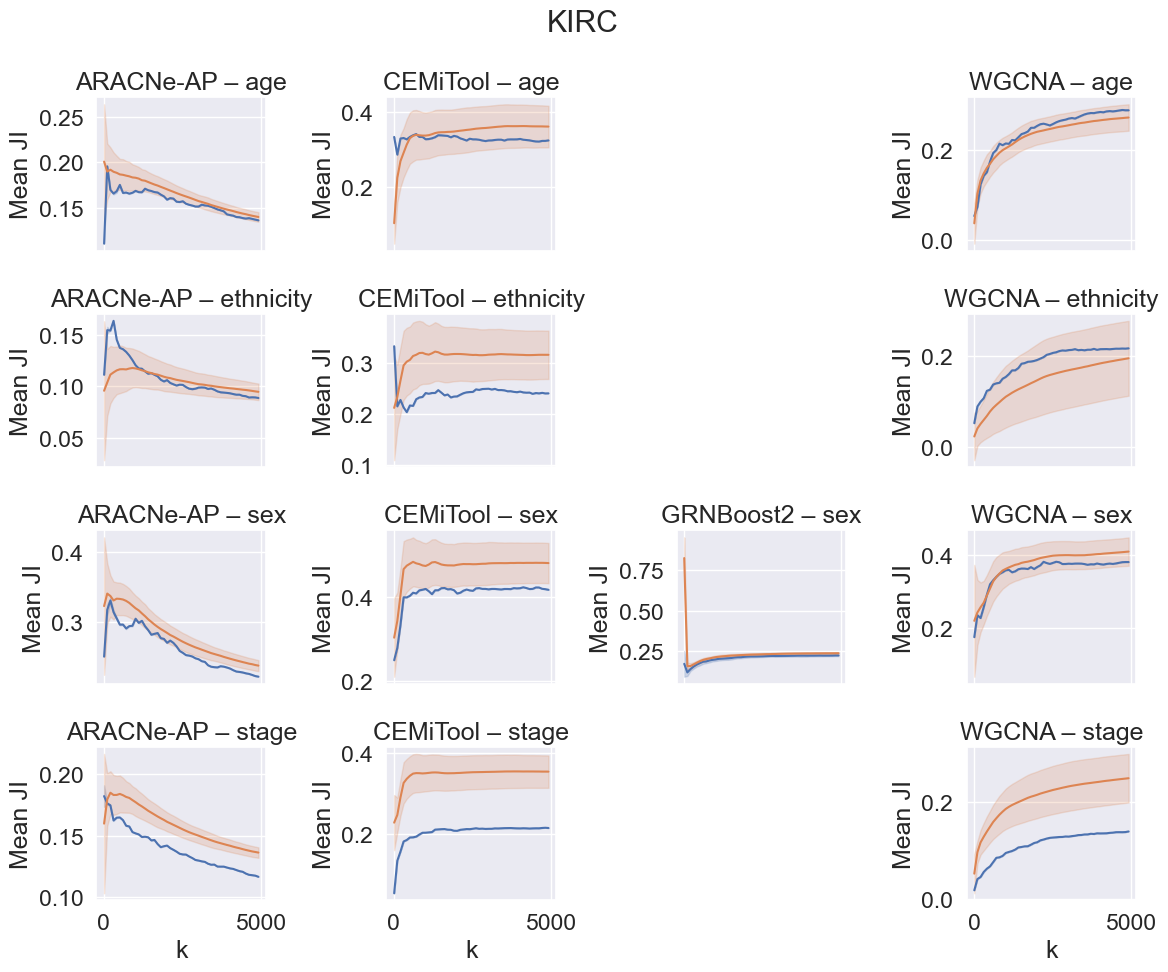

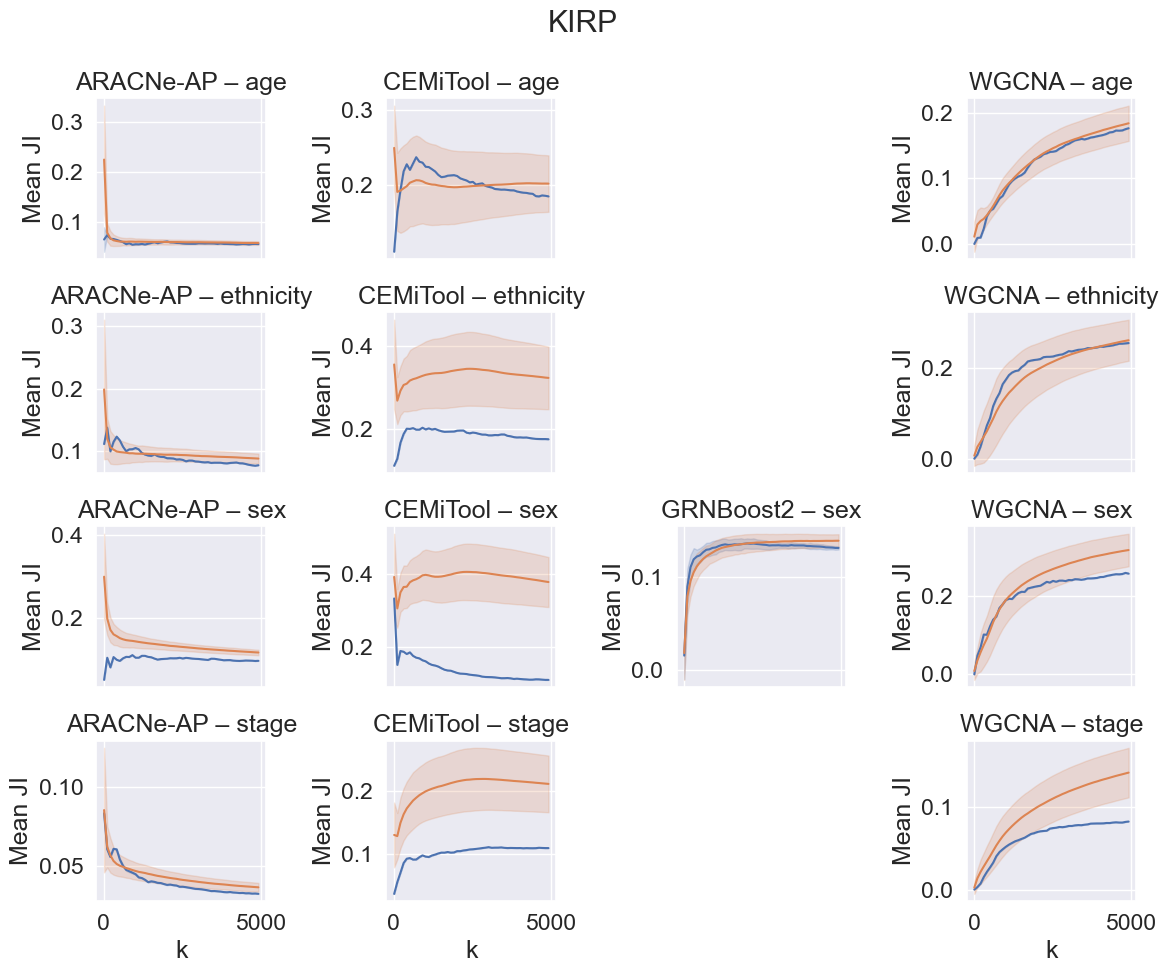

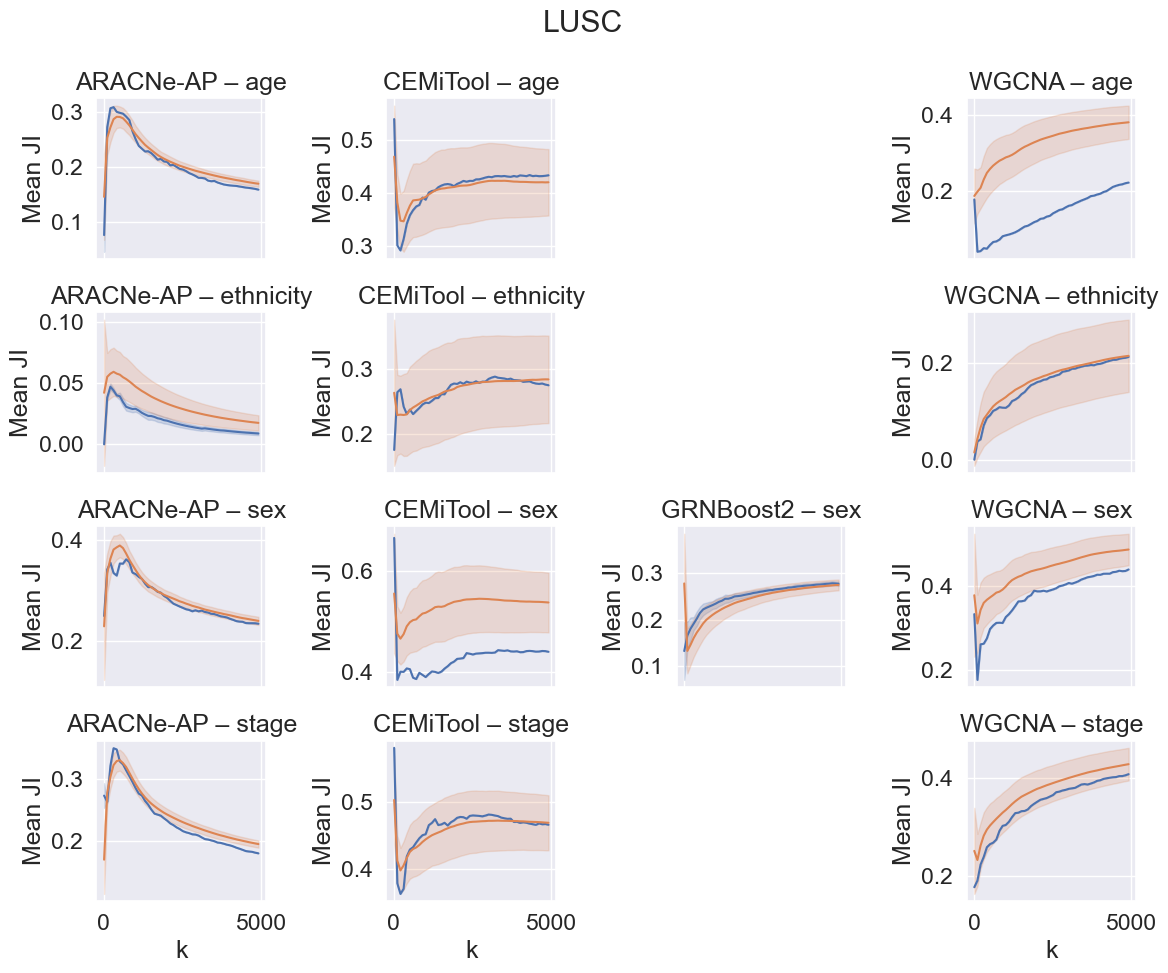

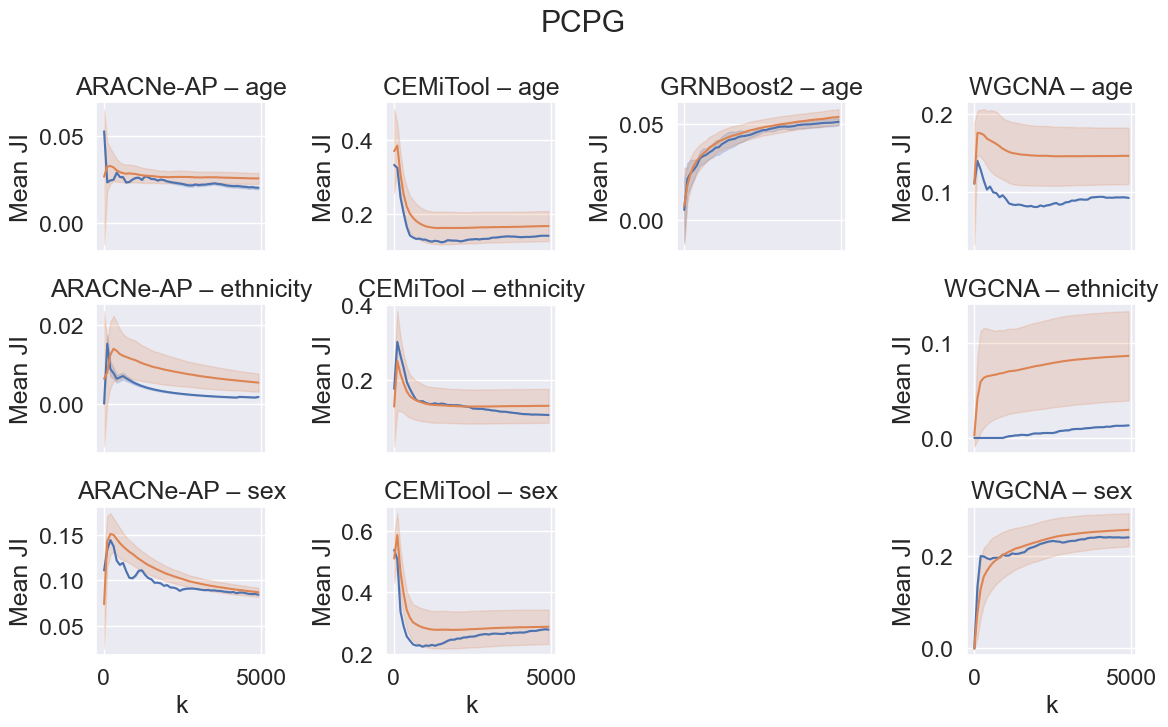

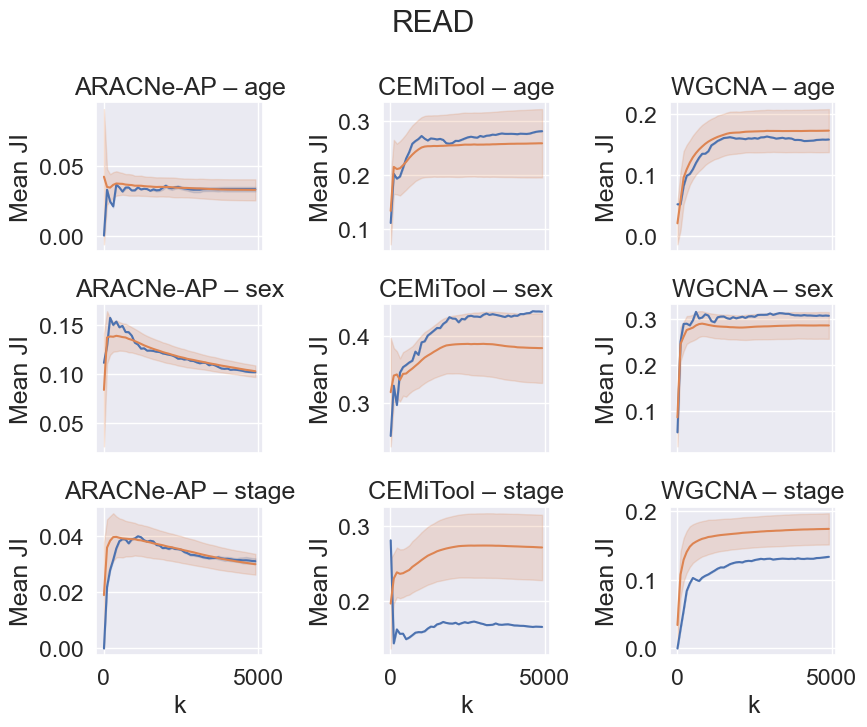

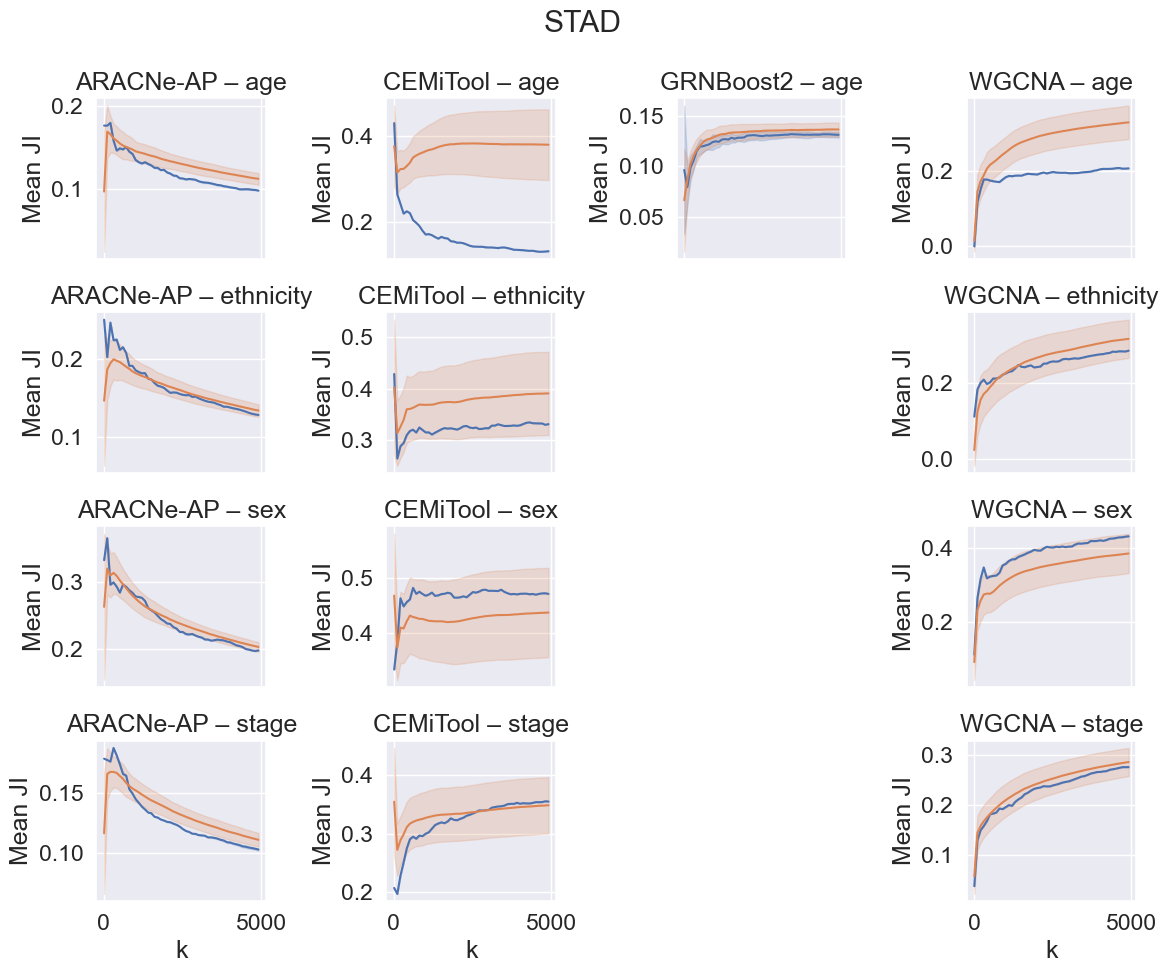

In [49]:
plt.style.use('default')
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
for ct_sel in ct_sels:
    JI_ct = JI_all[JI_all['Cohort']==ct_sel]
    confounders = sorted(list(set(JI_ct['Confounder/\nvariable'].values)))
    algos = sorted(list(set(JI_ct['Method'].values)))
    fig, axs = plt.subplots(len(confounders), len(algos), figsize=(3*len(algos), 2.5*len(confounders)), sharex=True, sharey=False)
    for i, conf in enumerate(confounders):
        JI_conf = JI_ct[JI_ct['Confounder/\nvariable'] == conf]
        for j, algo in enumerate(algos):
            JI_alg = JI_conf[JI_conf['Method'] == algo]
            if JI_alg.shape[0] == 0:
                axs[i, j].axis('off')
            else:
                sns.lineplot(data=JI_alg, x='k', y='Mean JI', errorbar='sd', ax=axs[i,j], hue='Partition type', legend=False)
                axs[i,j].set_title(f'{algo} – {conf}')
    fig.suptitle(ct_sel)
    fig.tight_layout()
    fig.savefig(f'plots/{ct_sel}_block_comparisons.pdf')

## Compute P-values of one-sided Mann-Whitney U-test for each k

In [50]:
mwus = pd.DataFrame(columns=['Method', 'Cohort', 'Confounder/\nvariable', 'k', 'mwu.pvalue'])
for alg_sel in ['ARACNe-AP', 'CEMiTool', 'GRNBoost2', 'WGCNA']:
    JI_ = JI_all[JI_all['Method'] == alg_sel]
    for cohort in ct_sels:
        coh = JI_[JI_['Cohort'] == cohort]
        for conf_sel in confs:
            conf = coh[coh['Confounder/\nvariable'] == conf_sel]
            if len(conf) == 0:
                continue
            c = conf[conf['Partition type']=='confounder-based partition']
            r = conf[conf['Partition type']=='random partition']
            for k in sorted(list(set(c['k']))):
                c_k = c[c['k'] == k]
                r_k = r[r['k'] == k]
                mwu = mannwhitneyu(c_k['Mean JI'],r_k['Mean JI'], alternative='less')
                df = pd.DataFrame([[alg_sel, cohort, conf_sel, k, mwu.pvalue]], columns=['Method', 'Cohort', 'Confounder/\nvariable', 'k', 'mwu.pvalue'])
                mwus = pd.concat([mwus, df])
                
mwus.reset_index(inplace=True)
mwus = mwus.drop('index', axis=1).drop('k', axis=1)

count = mwus.groupby(['Method', 'Cohort', 'Confounder/\nvariable']).count().reset_index()
count.rename(columns={'mwu.pvalue':'total.pvalues'}, inplace=True)

sign_ = mwus[mwus['mwu.pvalue'] < alpha]
sign_ = sign_.groupby(['Method', 'Cohort', 'Confounder/\nvariable']).count().reset_index()
sign_.rename(columns={'mwu.pvalue':'sign.pvalues'}, inplace=True)
sign = pd.merge(count, sign_,  how='left', left_on=['Method', 'Cohort', 'Confounder/\nvariable'],
              right_on=['Method', 'Cohort', 'Confounder/\nvariable']).fillna(0)
sign['frac'] = sign['sign.pvalues']/sign['total.pvalues']
_mwus = pd.DataFrame(sign).reset_index()
_mwus = _mwus[(_mwus['Method'] != 'GRNBoost2') & (_mwus['Method'] != 'GENIE3')]
_mwus['Confounder/\nvariable'] = pd.Categorical(_mwus['Confounder/\nvariable'], ['age', 'ethnicity', 'sex', 'stage'])
corr_coeff= _mwus.pivot(columns='Method',values='frac',index=['Cohort','Confounder/\nvariable']).corr()

## Generate plots for method-centric view – big plot

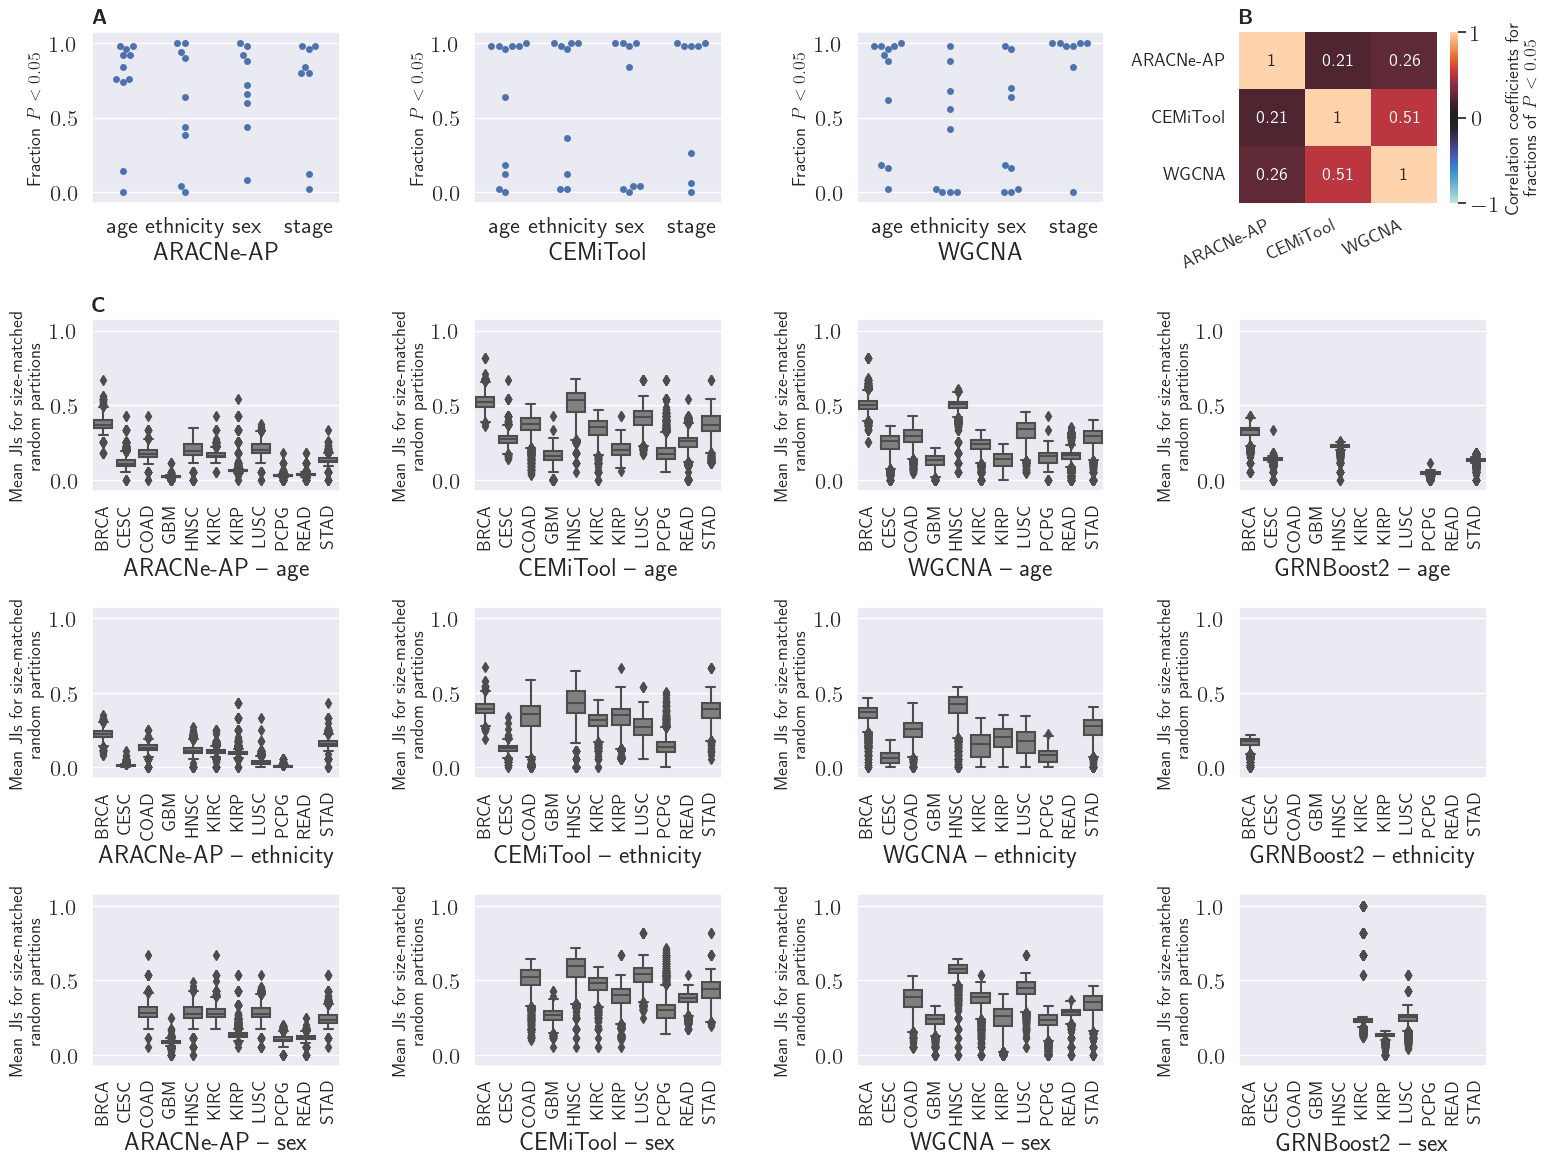

In [51]:
JI_all_random = JI_all[JI_all['Partition type'] == 'random partition']
JI_all_random = JI_all_random[JI_all_random['Confounder/\nvariable'] != 'stage']
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',{'axes.grid' : True})
confounders = sorted(list(set(JI_all_random['Confounder/\nvariable'].values)))
algos = ['ARACNe-AP','CEMiTool','WGCNA','GRNBoost2']
cohorts = sorted(list(set(JI_all_random['Cohort'].values)))
mosaic = [['ARACNe-AP','CEMiTool','WGCNA','heatmap'],
          [f'{algo} – age' for algo in algos],
          [f'{algo} – ethnicity' for algo in algos],
          [f'{algo} – sex' for algo in algos]]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(4*len(algos), 3*(len(confounders)+1)),sharex=False, sharey=False)
for algo in ['ARACNe-AP','CEMiTool','WGCNA']:
    axs[algo].set_ylim([-0.075, 1.075])
    _mwus_alg = _mwus[_mwus['Method'] == algo]
    sns.swarmplot(data=_mwus_alg,y='frac',x='Confounder/\nvariable',ax=axs[algo])
    axs[algo].set_ylabel('Fraction $P<0.05$',fontsize=13)
    axs[algo].set_xlabel(algo)
for conf in confounders:
    JI_conf = JI_all_random[JI_all_random['Confounder/\nvariable'] == conf]
    for algo in algos:
        conf_alg = f'{algo} – {conf}'
        axs[conf_alg].set_ylim([-0.075, 1.075])
        JI_alg = JI_conf[JI_conf['Method'] == algo]
        sns.boxplot(data=JI_alg,y='Mean JI',x='Cohort',ax=axs[conf_alg],order=cohorts,color='grey')
        axs[conf_alg].set_ylabel('Mean JIs for size-matched\nrandom partitions',fontsize=13)
        axs[conf_alg].set_xlabel(f'{algo} – {conf}')
        axs[conf_alg].set_xticklabels(axs[conf_alg].get_xticklabels(), rotation=90,fontsize=13)
    axs['ARACNe-AP'].set_title(r'\textbf{A}',loc='left', fontsize=15)
    axs['ARACNe-AP – age'].set_title(r'\textbf{C}',loc='left', fontsize=15)
sns.heatmap(corr_coeff,annot=True,center=0.0,vmin=-1,vmax=1,ax=axs['heatmap'],annot_kws={'fontsize':13})
colorbar = axs['heatmap'].collections[0].colorbar
colorbar.set_label('Correlation coefficients for\nfractions of $P<0.05$',fontsize=13)
axs['heatmap'].set_xticklabels(axs['heatmap'].get_xticklabels(), rotation=25, ha='right',fontsize=13)
axs['heatmap'].set_yticklabels(axs['heatmap'].get_yticklabels(), fontsize=13)
axs['heatmap'].set_xlabel('')
axs['heatmap'].set_ylabel('')
axs['heatmap'].set_title(r'\textbf{B}',loc='left', fontsize=15)
fig.tight_layout()
fig.savefig('plots/fig4big.pdf')

## Generate plots for method-centric view – small plot

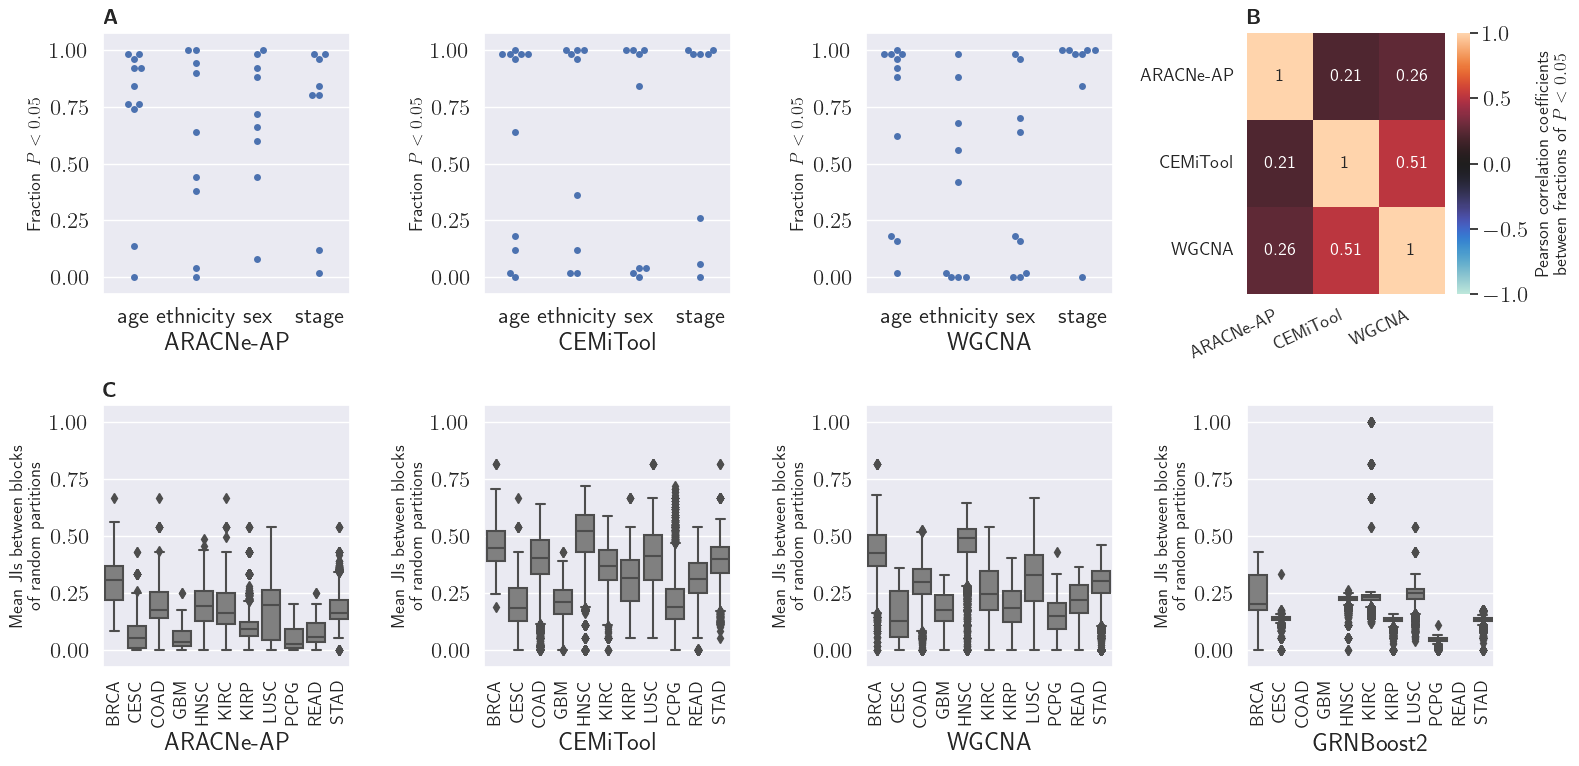

In [52]:
JI_all_random = JI_all[JI_all['Partition type'] == 'random partition']
JI_all_random = JI_all_random[JI_all_random['Confounder/\nvariable'] != 'stage']
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',{'axes.grid' : True})
confounders = sorted(list(set(JI_all_random['Confounder/\nvariable'].values)))
algos = ['ARACNe-AP','CEMiTool','WGCNA','GRNBoost2']
cohorts = sorted(list(set(JI_all_random['Cohort'].values)))
mosaic = [['ARACNe-AP','CEMiTool','WGCNA','heatmap'],
          ['ARACNe-AP,r','CEMiTool,r','WGCNA,r','GRNBoost2,r']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(4*4, 4*2),sharex=False, sharey=False)
for algo in ['ARACNe-AP','CEMiTool','WGCNA']:
    axs[algo].set_ylim([-0.075, 1.075])
    _mwus_alg = _mwus[_mwus['Method'] == algo]
    sns.swarmplot(data=_mwus_alg,y='frac',x='Confounder/\nvariable',ax=axs[algo])
    axs[algo].set_ylabel('Fraction $P<0.05$',fontsize=13)
    axs[algo].set_xlabel(algo)
for algo in algos:
    conf_alg = f'{algo},r'
    axs[conf_alg].set_ylim([-0.075, 1.075])
    JI_alg = JI_all_random[JI_all_random['Method'] == algo]
    sns.boxplot(data=JI_alg,y='Mean JI',x='Cohort',ax=axs[conf_alg],order=cohorts,color='grey')
    axs[conf_alg].set_ylabel('Mean JIs between blocks\nof random partitions',fontsize=13)
    axs[conf_alg].set_xlabel(algo)
    axs[conf_alg].set_xticklabels(axs[conf_alg].get_xticklabels(), rotation=90,fontsize=13)
axs['ARACNe-AP'].set_title(r'\textbf{A}',loc='left', fontsize=15)
axs['ARACNe-AP,r'].set_title(r'\textbf{C}',loc='left', fontsize=15)
sns.heatmap(corr_coeff,annot=True,center=0.0,vmin=-1,vmax=1,ax=axs['heatmap'],annot_kws={'fontsize':13})
colorbar = axs['heatmap'].collections[0].colorbar
colorbar.set_label('Pearson correlation coefficients\nbetween fractions of $P<0.05$',fontsize=13)
axs['heatmap'].set_xticklabels(axs['heatmap'].get_xticklabels(), rotation=25, ha='right',fontsize=13)
axs['heatmap'].set_yticklabels(axs['heatmap'].get_yticklabels(), fontsize=13)
axs['heatmap'].set_xlabel('')
axs['heatmap'].set_ylabel('')
axs['heatmap'].set_title(r'\textbf{B}',loc='left', fontsize=15)
fig.tight_layout()
fig.savefig('plots/fig4.pdf')

## Prepare data frames for plot showing results of the first part of the test protocol

In [53]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
cwd = os.getcwd()
alpha = 0.05

def align(pheno, expr):
    keep = pheno.index.isin(expr.index)
    pheno = pheno[keep]
    pheno = pheno[pheno.index.isin(expr.index)]
    samples = pheno.index            
    expr = expr.loc[samples]
    expr = expr.loc[:, (expr.std() != 0)]
    pheno = pheno[pheno.index.isin(expr.index)]
    return pheno, expr

def get_conf_partition(pheno_data_orig, confounder_selector, rank, thresh=0, verbose=False):
    pheno_data = pheno_data_orig.copy()
    indices = None
    blocks = []
    printer = []
    pheno_field = ''  
    if confounder_selector == 'age':
        pheno_field = 'age_at_initial_pathologic_diagnosis'
        if 'age_at_initial_pathologic_diagnosis' not in list(pheno_data.columns):
            pheno_field = 'age'
    elif confounder_selector == 'ethnicity':
        pheno_field = 'race.demographic'
        if 'race.demographic' not in list(pheno_data.columns):
            pheno_field = 'ethnicity'
    elif confounder_selector == 'sex':
        pheno_field = 'gender.demographic'
        if 'gender.demographic' not in list(pheno_data.columns):
            pheno_field = 'sex'
    elif confounder_selector == 'stage':
        pheno_field = 'tumor_stage.diagnoses'
        if 'tumor_stage.diagnoses' not in list(pheno_data.columns):
            pheno_field = 'stage'
        print('stage x:')
        print(len(pheno_data[pheno_data[pheno_field].str.strip().isin(['stage x'])]))
        pheno_data = pheno_data[pheno_data[pheno_field] != 'stage x']
        pheno_data.loc[pheno_data['tumor_stage.diagnoses'].str.strip().isin(['stage ia', 'stage ib', 'stage ic']), pheno_field] = 'stage i'
        pheno_data.loc[pheno_data['tumor_stage.diagnoses'].str.strip().isin(['stage iia', 'stage iib', 'stage iic']), pheno_field] = 'stage ii'
        pheno_data.loc[pheno_data['tumor_stage.diagnoses'].str.strip().isin(['stage iiia', 'stage iiib', 'stage iiic', 'stage iv', 'stage iva', 'stage ivb', 'stage ivc']), pheno_field] = 'stage iii'
    elif confounder_selector == 'type':
        pheno_field = 'cohort'
    print('na:')
    print(len(pheno_data[pheno_data[pheno_field].isna()])+len(pheno_data[pheno_data[pheno_field] == 'not reported']))
    pheno_data = pheno_data[pheno_data[pheno_field].notna()]
    pheno_data = pheno_data[pheno_data[pheno_field] != 'not reported']
    if confounder_selector != 'age':
        blocks = sorted(list(set(pheno_data[pheno_field].str.strip().values)))
        for block_attr in blocks:
            samples = pheno_data.loc[pheno_data[pheno_field].str.strip() == block_attr].index.tolist()
            if len(samples) >= thresh:
                printer.append((samples, block_attr))
    elif confounder_selector == 'age':       
        samples_lower = []
        samples_upper = []
        for cohort in set(pheno_data['cohort'].str.strip().values):
            pheno_cohort = pheno_data[pheno_data['cohort'] == cohort]
            pheno_cohort = pheno_cohort[pheno_cohort[pheno_field] != 'na']
            lower, upper = pheno_cohort[pheno_field].quantile(0.25), pheno_cohort[pheno_field].quantile(0.75)
            if verbose:
                print(f'\tlower quartile: [{pheno_cohort[pheno_field].values.min()},{lower}]')
                print(f'\tupper quartile: ({upper},{pheno_cohort[pheno_field].values.max()}]')
            samples_lower.extend(pheno_cohort.loc[pheno_cohort[pheno_field] <= lower].index.tolist())
            samples_upper.extend(pheno_cohort.loc[pheno_cohort[pheno_field] > upper].index.tolist())
        if len(samples_lower) >= thresh and len(samples_upper) >= thresh:
            printer.append((samples_lower, 'lower'))
            printer.append((samples_upper, 'upper'))
    return printer

def stage_conf_chi(pheno):
    confs = ['age', 'ethnicity', 'sex', 'stage']
    sc = {'age':np.nan, 'ethnicity':np.nan, 'sex':np.nan}
    for conf in confs:
        out = []
        confusion_table = pd.DataFrame()
        orig_conf_partition = get_conf_partition(pheno, conf, 0, thresh=20, verbose=True)
        for bl in orig_conf_partition:
            block = bl[0]
            try:
                stage_partition = get_conf_partition(pheno[pheno.index.isin(block)], 'stage', 0)
            except:
                print('no stage variable')
                continue
            for stage_block in stage_partition:
                confusion_table.loc[stage_block[1], bl[1]] = len(stage_block[0])
        try:
            if len(confusion_table) <= 1:
                continue
            confusion_table = confusion_table.dropna()
            chi2, p, dof, ex = chi2_contingency(confusion_table, correction=False)
            sc[str(conf)] = p
        except:
            continue
    return sc

def get_expression_data(cohort):
    expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.htseq_fpkm.tsv'), sep='\t', header=0, index_col=0)
    expression_data.columns = expression_data.columns.str.split('.').str[0].tolist()
    # gene filtering is removed here, because it does not affect the set of samples present in the file
    return expression_data

def get_pheno_data(cohort):
    tissue_type_field, tissue_type = 'sample_type.samples', 'Primary Tumor'
    pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.GDC_phenotype.tsv'), sep='\t', header=0, index_col='submitter_id.samples')
    assert len(pheno_data.iloc[0]) == len(pheno_data.iloc[0].values)
    pheno_data['cohort'] = str(cohort)
    pheno_data =  pheno_data[pheno_data[tissue_type_field] == tissue_type]
    return pheno_data

df = pd.DataFrame(columns=['cohort', 'age', 'ethnicity', 'sex'])
cohorts = ['BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'PCPG', 'READ', 'STAD']
for cohort in cohorts:
    # read single data
    expr = get_expression_data(cohort)
    pheno = get_pheno_data(cohort)
    # align pheno and expr
    pheno, expr = align(pheno, expr)
    sc = stage_conf_chi(pheno)
    temp = pd.DataFrame({'cohort':[str(cohort)], 'age':[sc['age']], 'ethnicity':[sc['ethnicity']], 'sex':[sc['sex']]})
    df = pd.concat([df, temp])  
    
df_work = df.copy()
df_work = df_work.dropna().reset_index()
df_work = df_work.reset_index()
df_work.index = df_work['cohort'].values
df_work = df_work.drop(['cohort', 'index', 'level_0'], axis=1)
df_work.columns = ['age', 'ethnicity', 'sex']

def convert_pvalue_to_asterisks(p):
    if p <= 0.0001:
        return 4
    elif p <= 0.001:
        return 3
    elif p <= 0.01:
        return 2
    elif p <= 0.05:
        return 1
    else:
        return 0

mwus = pd.DataFrame(columns=['Method', 'Cohort', 'Confounder/\nvariable', 'k', 'mwu.pvalue'])
algs = ['GRNBoost2']
for alg_sel in algs:
    JI_ = JI_all[JI_all['Method'] == alg_sel]
    for cohort in ct_sels:
        coh = JI_[JI_['Cohort'] == cohort]
        for conf_sel in confs:
            conf = coh[coh['Confounder/\nvariable'] == conf_sel]
            if len(conf) == 0:
                continue
            c = conf[conf['Partition type']=='confounder-based partition']
            r = conf[conf['Partition type']=='random partition']
            for k in sorted(list(set(c['k']))):
                c_k = c[c['k'] == k]
                r_k = r[r['k'] == k]
                mwu = mannwhitneyu(c_k['Mean JI'],r_k['Mean JI'], alternative='less')
                df = pd.DataFrame([[alg_sel, cohort, conf_sel, k, mwu.pvalue]], columns=['Method', 'Cohort', 'Confounder/\nvariable', 'k', 'mwu.pvalue'])
                mwus = pd.concat([mwus, df])
mwus.reset_index(inplace=True)
mwus['Cohort - Variable'] = mwus['Cohort'] + ' – ' + mwus['Confounder/\nvariable']
mwus['k'] = pd.Categorical(mwus['k'], range(10, 5000, 100))
mwus['-log(p)'] = -np.log10(mwus['mwu.pvalue'])
cohort_confs = sorted(list(set(mwus['Cohort - Variable'].values)))

na:
1
	lower quartile: [26.0,49.0]
	upper quartile: (67.0,90.0]
stage x:
3
na:
4
stage x:
3
na:
3
na:
95
stage x:
0
na:
0
stage x:
4
na:
1
stage x:
5
na:
8
na:
1
stage x:
12
na:
11
stage x:
12
na:
12
stage x:
0
na:
0
stage x:
0
na:
0
stage x:
0
na:
0
na:
0
	lower quartile: [20,38.0]
	upper quartile: (56.25,88]
stage x:
0
na:
80
stage x:
0
na:
76
na:
36
stage x:
0
na:
20
stage x:
0
na:
30
stage x:
0
na:
209
na:
0
stage x:
0
na:
304
stage x:
0
na:
304
na:
2
	lower quartile: [31.0,58.0]
	upper quartile: (77.0,90.0]
stage x:
0
na:
4
stage x:
0
na:
2
na:
173
stage x:
0
na:
0
stage x:
0
na:
10
na:
2
stage x:
0
na:
4
stage x:
0
na:
7
stage x:
0
na:
13
stage x:
0
na:
0
stage x:
0
na:
0
stage x:
0
na:
0
na:
1
	lower quartile: [21.0,51.25]
	upper quartile: (69.75,89.0]
stage x:
0
na:
39
stage x:
0
na:
39
na:
2
stage x:
0
na:
138
na:
1
stage x:
0
na:
54
stage x:
0
na:
100
stage x:
0
na:
155
na:
1
	lower quartile: [19.0,53.0]
	upper quartile: (69.0,90.0]
stage x:
0
na:
19
stage x:
0
na:
18
na:
15


## Generate plots showing results of first part of the test protocol

/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1158/3843068626.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1158/3843068626.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1158/3843068626.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1158/3843068626.py:56: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


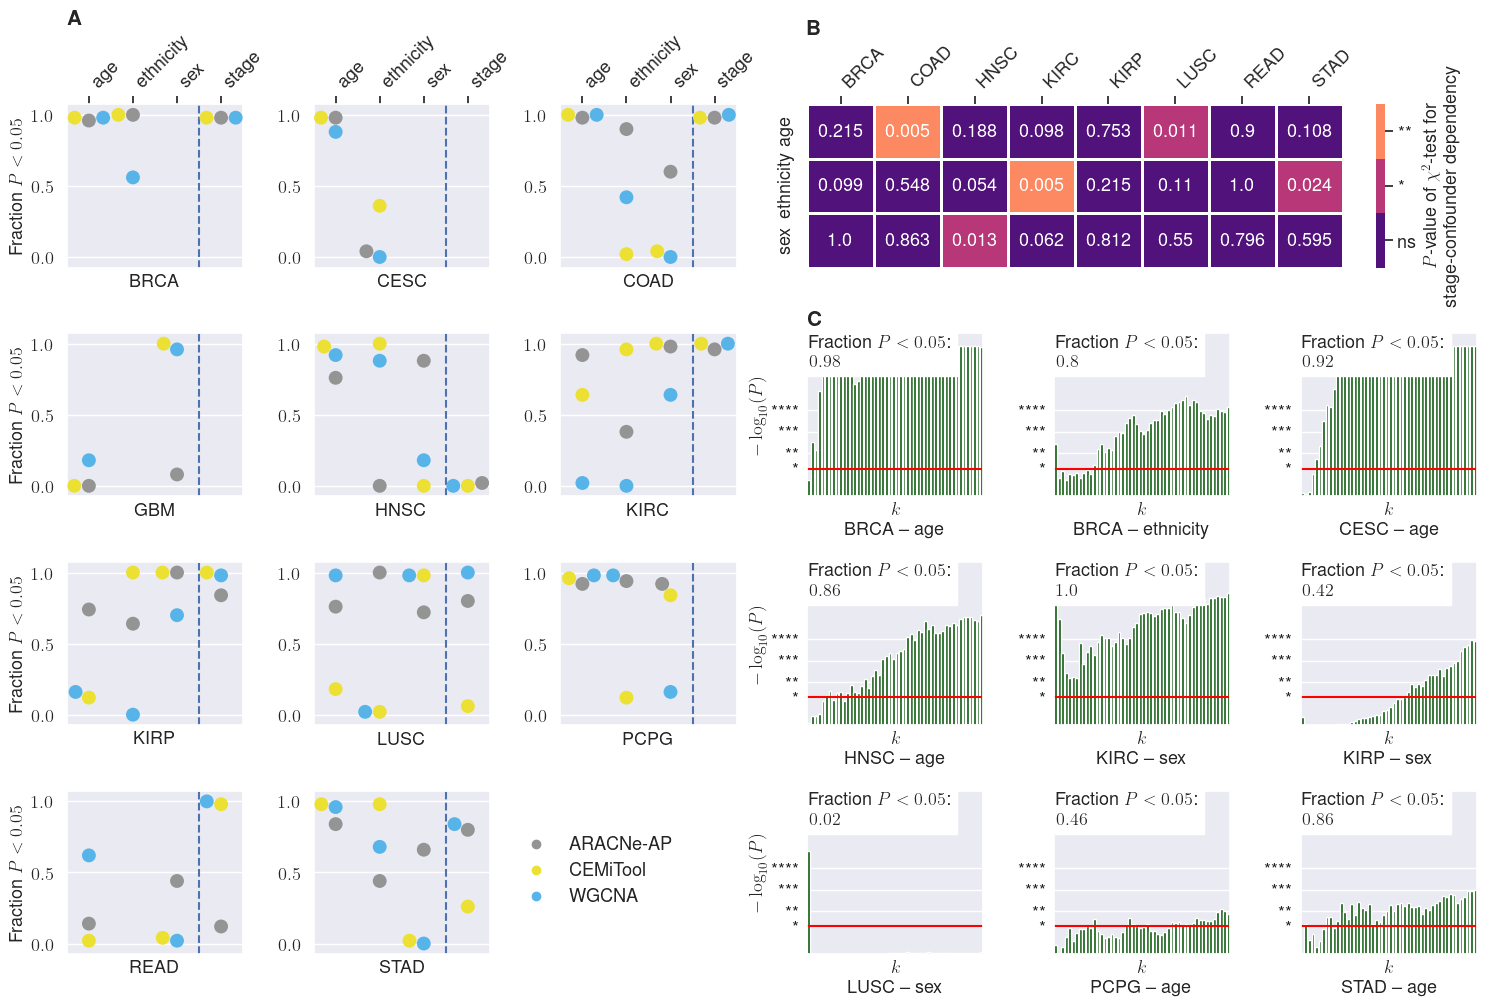

In [54]:
sns.set(font_scale=1.2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
mosaic = [ct_sels[:3] + ['heatmap' for _ in range(3)],
          ct_sels[3:6] + cohort_confs[:3],
          ct_sels[6:9] + cohort_confs[3:6],
          ct_sels[9:11] + ['.'] + cohort_confs[6:9]]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(6*2.5,4*2.5),sharex=False, sharey=False)
for ct_sel in ct_sels:
    _mwus_ct = _mwus[_mwus['Cohort'] == ct_sel]
    sns.swarmplot(data=_mwus_ct, ax=axs[ct_sel], x='Confounder/\nvariable', y='frac', hue='Method', s=10, palette=sns.color_palette('colorblind')[7:10])
    axs[ct_sel].axvline(x=2.5, linestyle='--')
    axs[ct_sel].set_ylim([-0.075, 1.075])
    if ct_sel == ct_sels[0]:
        axs[ct_sel].set_title(r'\textbf{A}',loc='left', fontsize=15)
        sns.move_legend(axs[ct_sel], "lower center", frameon=False, ncol=1, title=None, bbox_to_anchor=(3,-4))
    else:
        axs[ct_sel].legend().set_visible(False)
    if ct_sel in ct_sels[:3]:
        axs[ct_sel].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
    else:
        axs[ct_sel].tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
    axs[ct_sel].set(xlabel=None, ylabel=None)
    axs[ct_sel].set_xlabel(ct_sel, fontsize=13)
    if ct_sel in [ct_sels[3*i] for i in range(4)]:
        axs[ct_sel].set_ylabel('Fraction $P<0.05$', labelpad=3, fontsize=13)

for cohort_conf in cohort_confs:
    axs[cohort_conf].set_ylim([0, 7.6])
    axs[cohort_conf].axhline(y=-np.log10(0.05), linestyle='-', color='red')
    axs[cohort_conf].tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
    mwus_cohort_conf = mwus[mwus['Cohort - Variable'] == cohort_conf]
    sns.barplot(data=mwus_cohort_conf, x='k', y='-log(p)', ax=axs[cohort_conf], color='darkgreen')
    axs[cohort_conf].set(ylabel=None)
    axs[cohort_conf].set_yticks([-np.log10(0.05),-np.log10(0.01),-np.log10(0.001),-np.log10(0.0001)])
    axs[cohort_conf].set_yticklabels(['*','**','***','****'], fontsize=13)
    axs[cohort_conf].tick_params(axis='y', which='major', pad=0)
    axs[cohort_conf].set_xlabel('$k$\n'+cohort_conf, fontsize=13)
    if cohort_conf in [cohort_confs[3*i] for i in range(3)]:
        axs[cohort_conf].set_ylabel('$-\log_{10}(P)$', fontsize=13,  labelpad=3)
    if cohort_conf == cohort_confs[0]:
        axs[cohort_conf].set_title(r'\textbf{C}',loc='left', fontsize=15)
    frac = mwus_cohort_conf[mwus_cohort_conf['mwu.pvalue'] < 0.05].shape[0] / mwus_cohort_conf.shape[0]
    axs[cohort_conf].text(.01, .99, f'Fraction $P<0.05$:\n${frac}$', ha='left', va='top', transform=axs[cohort_conf].transAxes,
                          fontsize=13, backgroundcolor='white')
cmap2 = sns.color_palette("magma", 3)

ast = pd.DataFrame(np.array([df_work['age'].apply(convert_pvalue_to_asterisks).to_numpy(),
               df_work['ethnicity'].apply(convert_pvalue_to_asterisks).to_numpy(),
               df_work['sex'].apply(convert_pvalue_to_asterisks).to_numpy()]), index=df_work.columns,
                columns = df_work.index)#.T

cur = df_work.T
cur = round(cur, 3)
plt.tight_layout()
sns.heatmap(ast, ax=axs['heatmap'], vmin=0, vmax=2, annot=cur, cmap=cmap2, cbar=True, fmt = '', annot_kws={'fontsize':13}, linewidths=1)
axs['heatmap'].set_yticklabels(axs['heatmap'].get_ymajorticklabels(),fontsize=13)
#axs['heatmap'].set_xticklabels(axs['heatmap'].get_xmajorticklabels())
axs['heatmap'].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs['heatmap'].set_xticklabels(axs['heatmap'].get_xticklabels(), rotation=45, ha='left',fontsize=13)
colorbar = axs['heatmap'].collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r / 3 * (0.5 + i) for i in range(3)])
colorbar.set_ticklabels(['ns','*','**'], fontsize='13')
colorbar.set_label('$P$-value of $\chi^2$-test for\nstage-confounder dependency', fontsize='13')
axs['heatmap'].set_title(r'\textbf{B}',loc='left', fontsize=15)
fig.subplots_adjust(left=0.05,
                    bottom=0.05,
                    right=.99,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
fig.savefig('plots/fig2.pdf')

## Generate data frames for second part of the test protocol

In [55]:
alg_sels = ['WGCNA', 'CEMITOOL', 'ARACNE', 'GRNBOOST2']
ct_sels = ['BRCA', 'CESC', 'HNSC', 'STAD', 'KIRC', 'KIRP']
conf_sels = ['age_at_initial_pathologic_diagnosis','race.demographic','gender.demographic']
blocks = {'age_at_initial_pathologic_diagnosis': ['lower', 'upper'],
          'race.demographic': ['asian', 'black or african american', 'white'],
          'gender.demographic': ['female', 'male']}
fro = 0
to = 10
cwd = os.getcwd()
JI = {'Confounder': [], 'Cohort': [], 'Method': [], 'Demographic group': [], 'Sampling': [], 'partID': [], 'k': [], 'Mean JI': []}
for alg_sel in alg_sels:
    for conf_sel in conf_sels:
        for ct_sel in ct_sels:
            for block in blocks[conf_sel]:
                path = os.path.join(cwd, 'mean_JI_G_all_comparisons')
                for i in range(fro, to):
                    for t in ['conf', 'rnd']:
                        filename = f'g_all_{t}_{i}_{str(alg_sel)}_{str(conf_sel)}_{str(ct_sel)}_{block}_jaccInd.csv'
                        try:
                            res = pd.read_csv(os.path.join(path, filename), sep=',', usecols=['k','mean JI'])
                            num_rows = res.shape[0]
                            JI['Confounder'] += [conf_sel for _ in range(num_rows)]
                            JI['Cohort'] += [ct_sel for _ in range(num_rows)]
                            JI['Method'] += [alg_sel for _ in range(num_rows)]
                            if conf_sel == 'age_at_initial_pathologic_diagnosis':
                                subgroup = f'{block.capitalize()} age quartile'
                            else:
                                subgroup = f'{block.capitalize()}'
                            JI['Demographic group'] += [subgroup for _ in range(num_rows)]
                            if t == 'rnd':
                                JI['Sampling'] += ['Size-matched random' for _ in range(num_rows)]
                            else:
                                JI['Sampling'] += ['Demography-based' for _ in range(num_rows)]
                            JI['partID'] += [i for _ in range(num_rows)]
                            JI['k'] += list(res['k'])
                            JI['Mean JI'] += list(res['mean JI'])
                        except:
                            continue
JI = pd.DataFrame(data=JI)
JI['Confounder'] = JI['Confounder'].replace(['age_at_initial_pathologic_diagnosis'], 'age').replace(['race.demographic'], 'ethnicity').replace(['gender.demographic'], 'sex')
JI = JI.replace('ARACNE', 'ARACNe-AP').replace('CEMITOOL', 'CEMiTool').replace('GRNBOOST2', 'GRNBoost2').replace('Black or african american', 'Black or African American')
JI = JI[JI['k']%100 == 10]
JI['Cohort – confounder'] = JI['Cohort'] + ' – ' + JI['Confounder']
JI['Method'] = pd.Categorical(JI['Method'], ['ARACNe-AP', 'CEMiTool', 'GRNBoost2', 'WGCNA'])
JI['Cohort – confounder'] = pd.Categorical(JI['Cohort – confounder'], list(JI['Cohort – confounder'].unique()))
JI['Demographic group'] = pd.Categorical(JI['Demographic group'], list(JI['Demographic group'].unique()))

## Plot results of second part of the test protocol

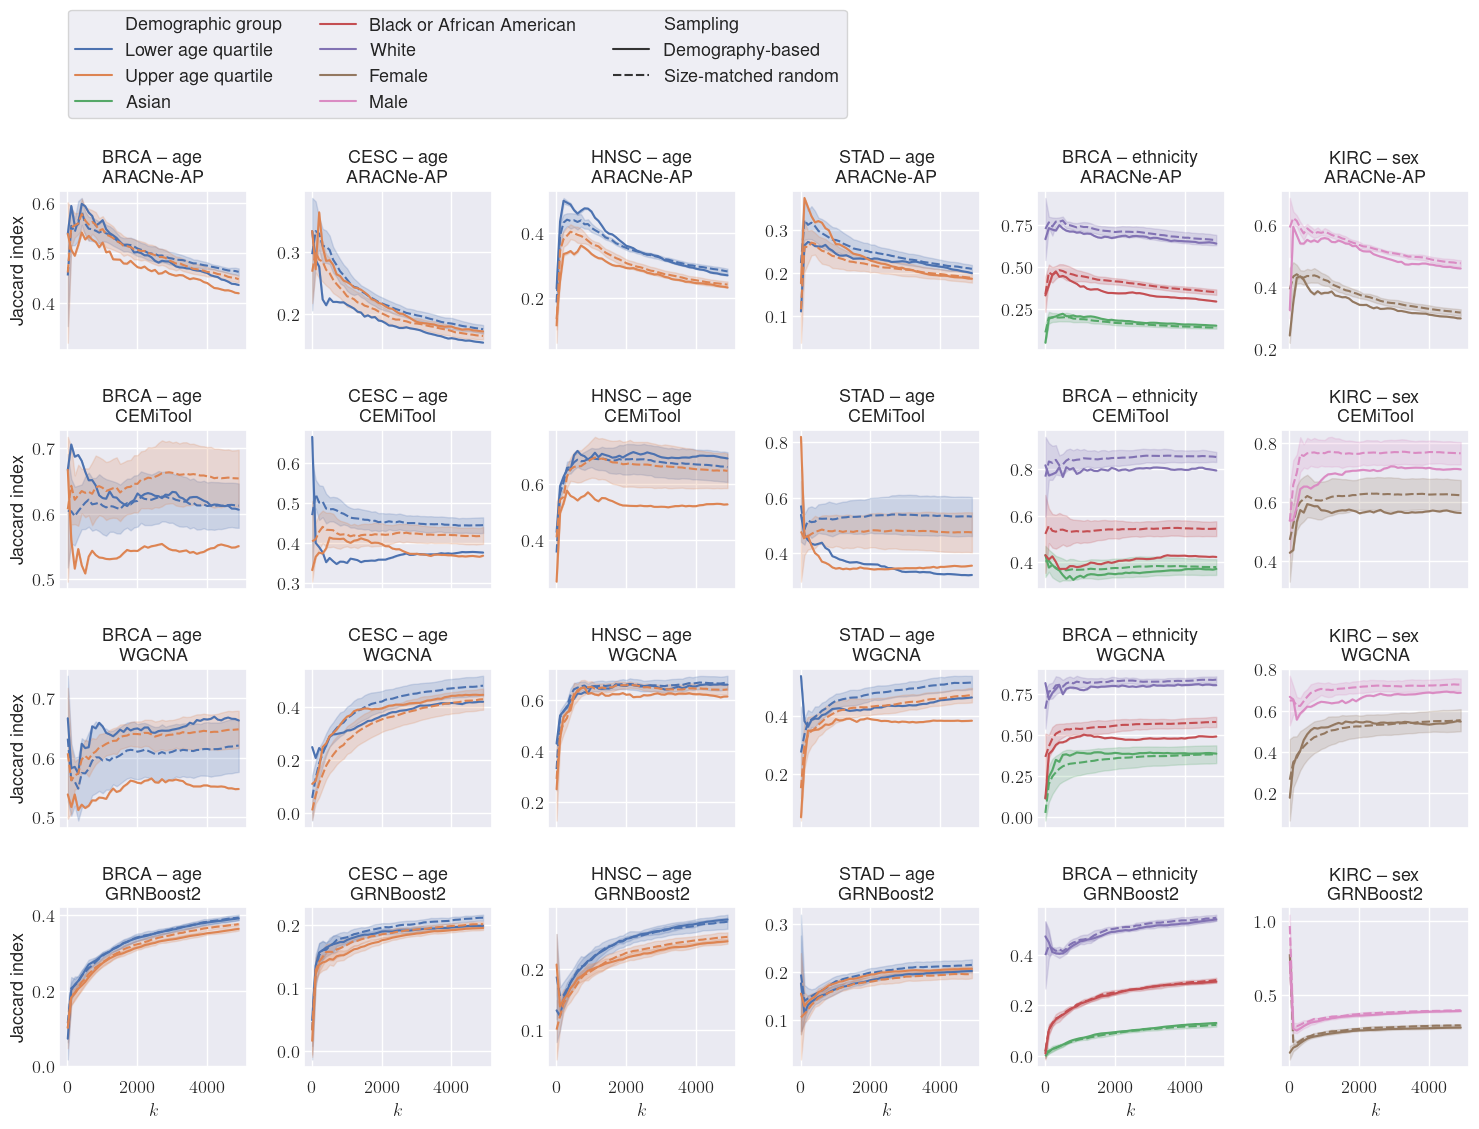

In [56]:
sns.set(font_scale=1.2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
selected_coco_pairs = ['BRCA – age','CESC – age', 'HNSC – age','STAD – age','BRCA – ethnicity','KIRC – sex']
algos = list(set(JI['Method'].values))
algos = ['ARACNe-AP','CEMiTool', 'WGCNA', 'GRNBoost2']
fig, axs = plt.subplots(len(algos), len(selected_coco_pairs), figsize=(6*2.5, 3*len(algos)), sharex=True, sharey=False)
for j, coco in enumerate(selected_coco_pairs):
    JI_coco = JI[JI['Cohort – confounder'] == coco]
    for i, algo in enumerate(algos):
        JI_alg = JI_coco[JI_coco['Method'] == algo]
        sns.lineplot(data=JI_alg, x='k', y='Mean JI', errorbar='sd', ax=axs[i,j], style='Sampling', hue='Demographic group')
        if i == 0 and j == 0:
            sns.move_legend(axs[i,j], "lower left", ncol=3, bbox_to_anchor=(0.0, 1.4), fontsize=13)
        else:
            axs[i,j].legend().set_visible(False)
        axs[i,j].set_title(f'{coco}\n{algo}', fontsize=13)
        axs[i,j].set_xlabel('$k$', fontsize=13)
        if j == 0:
            axs[i,j].set_ylabel('Jaccard index', fontsize=13)
        else:
            axs[i,j].set_ylabel('')
        axs[i,j].tick_params(axis='y',pad=-3)
fig.subplots_adjust(left=0.05,
                    bottom=0.06,
                    right=.99,
                    top=0.79,
                    wspace=0.3,
                    hspace=0.5)
fig.savefig('plots/fig3.pdf')